# MARCOT-HR Estimator Code

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

## Formules used

Modes supported by a fibre:

\begin{equation}
V=\frac{2\pi r_{core}}{\lambda}NA
\end{equation}

\begin{equation}
M=\frac{V^2}{2}
\end{equation}

Where $r_{core}$ is the radius of the fibre core, $NA$

In [19]:
# Telescope 

def marcot_hr_estimator(
    module_diameter_m = 5,
    ota_diameter_m = 0.406,
    f_number_ota = 8,
    seeing_fwhm_arcsec = 0.85,
    use_tip_tilt = False,
    target_encircled_energy = 0.95,
    fiber_NA_in=0.1, # Numerical aperture of input fibers
    fiber_NA_out=0.22, # Numerical aperture of output fiber
    wavelength_min_nm=500, # Minimun wavelength [nm]
    wavelength_max_nm=1000, # Maximun wavelength [nm]
    desired_resolution = 100000,
    magnification_factor = 1.2,
    pseudorendija = True,
    super_pl = False
):
    # Step 1: Area to Collect
    module_area = math.pi * (module_diameter_m / 2)**2
    ota_area = math.pi * (ota_diameter_m / 2)**2
    n_otas = math.ceil(module_area / ota_area)

    # Step 2: OTA focal length and plate scale
    ota_diameter_mm = ota_diameter_m * 1000
    focal_length_mm = f_number_ota * ota_diameter_mm
    plate_scale_arcsec_per_mm = 206265 / focal_length_mm

    # Step 3: Effective PSF considering tip/tilt
    effective_seeing_arcsec = seeing_fwhm_arcsec * (0.7 if use_tip_tilt else 1.0)

    # Step 4: Fiber core size calculation
    psf_fwhm_mm = effective_seeing_arcsec / plate_scale_arcsec_per_mm
    # Approximate to collect 90-95% of the energy: 1.5 × FWHM
    fiber_core_mm = 1.5 * psf_fwhm_mm
    fiber_core_microns = fiber_core_mm * 1000

    # Step 5: Fiber input parameters
    fiber_core_m = fiber_core_microns * 1e-6
    wavelengths_m = [wavelength_min_nm * 1e-9, wavelength_max_nm * 1e-9]

    modes_per_fiber = []
    for wl in wavelengths_m:
        V = (2 * math.pi * (fiber_core_m / 2) / wl) * fiber_NA_in
        M = (V**2) / 2
        modes_per_fiber.append(M)

    # Step 6: Total modes per module
    modes_total_per_module = [n_otas * m for m in modes_per_fiber]

    # Step 7: Calculate necessary fiber core size for module output
    wl_short = wavelengths_m[0]
    V_required = math.sqrt(2 * modes_total_per_module[0])
    a_required_m = (V_required * wl_short) / (2 * math.pi * fiber_NA_out)
    core_required_microns = 2 * a_required_m * 1e6

    # Step 8: Match to nearest commercial fiber size
    if core_required_microns <= 100:
        fiber_core_output_microns = 100
    elif core_required_microns <= 200:
        fiber_core_output_microns = 200
    elif core_required_microns <= 300:
        fiber_core_output_microns = 300
    else:
        fiber_core_output_microns = 400

    # CARMENES uses 100 micron fibers
    # Calculate fibers needed if forced to 100 micron outputs
    forced_output_core_microns = 100
    a_forced_output_m = (forced_output_core_microns / 2) * 1e-6
    V_forced_output = (2 * math.pi * a_forced_output_m / wl_short) * fiber_NA_out
    modes_per_forced_output_fiber = (V_forced_output**2) / 2

    fibers_per_module_output = math.ceil(modes_total_per_module[0] / modes_per_forced_output_fiber)
    modes_per_each_100_micron_fiber = modes_total_per_module[0] / fibers_per_module_output

    # Step 9: Global MARCOT collection
    total_modules = math.ceil((math.pi * (15 / 2)**2) / module_area)

    if pseudorendija:
        total_fibers_pseudorendija = total_modules * fibers_per_module_output
    elif super_pl:
        total_modes_all_modules = total_modules * modes_total_per_module[0]
        num_super_output_fibers = math.ceil(total_modes_all_modules / modes_per_forced_output_fiber)
        total_fibers_pseudorendija = num_super_output_fibers
    else:
        total_fibers_pseudorendija = total_modules * fibers_per_module_output

    # Step 10: Spectrograph optics estimation
    fiber_core_mm_entry = fiber_core_microns / 1000  # Convert microns to mm
    beam_diameter_mm = fiber_core_mm_entry * magnification_factor * desired_resolution

    base_volume_m3 = 14  # ESPRESSO baseline
    base_beam_mm = 200

    volume_scale = (beam_diameter_mm / base_beam_mm)**3
    spectrograph_volume_m3 = base_volume_m3 * volume_scale
    spectrograph_weight_kg = 4000 * volume_scale
    base_cost_meur = 6
    cost_estimate_meur = base_cost_meur * volume_scale

    results = {
        "Module diameter (m)": module_diameter_m,
        "OTA diameter (m)": ota_diameter_m,
        "Number OTAs needed": n_otas,
        "F-number OTA": f_number_ota,
        "Effective focal length (mm)": focal_length_mm,
        "Seeing FWHM (arcsec)": seeing_fwhm_arcsec,
        **({"Effective seeing with tip/tilt (arcsec)": effective_seeing_arcsec} if use_tip_tilt else {}),
        "Calculated fiber core input (microns)": fiber_core_microns,
        "Modes per fiber (500nm, 1000nm)": np.round(modes_per_fiber,0),
        "Total modes per module (500nm, 1000nm)": np.round(modes_total_per_module,0),
        "Calculated output fiber core (microns)": core_required_microns,
        "Selected commercial fiber core (microns)": fiber_core_output_microns,
        "Fibers of PL output per module if forced to 100 microns": fibers_per_module_output,
        "Modes carried by each 100 micron fiber": math.ceil(modes_per_each_100_micron_fiber),
        "Total modules": total_modules,
        "Total fibers at pseudorendija": total_fibers_pseudorendija,
        
        # Separador
        "": "",
        
        "Beam diameter in spectrograph (mm)": beam_diameter_mm,
        "Spectrograph volume (m³)": spectrograph_volume_m3,
        "Spectrograph weight (kg)": spectrograph_weight_kg,
        "Cost estimate (MEUR)": cost_estimate_meur,
        "Use tip/tilt": use_tip_tilt,
        "Magnification factor": magnification_factor,
        "Pseudorendija": pseudorendija,
        "Super-PL": super_pl
    }

    return results

###############################################################################################################
# Photonic Lantern

    
###############################################################################################################
# Instrument


In [20]:
# MARCOT-HR Estimator Code

# Example usage
if __name__ == "__main__":
    parameters = marcot_hr_estimator(
        module_diameter_m = 5,
        ota_diameter_m = 0.406,
        f_number_ota = 8,
        seeing_fwhm_arcsec = 0.85,
        use_tip_tilt = False,
        target_encircled_energy = 0.95,
        fiber_NA_in = 0.1,
        fiber_NA_out = 0.22,
        wavelength_min_nm = 500,
        wavelength_max_nm = 1000,
        desired_resolution = 100000,
        magnification_factor = 1.2,
        #pseudorendija=False,
        #super_pl=True
        pseudorendija = True,
        super_pl = False
    )

    #for key, value in parameters.items():
    #    print(f"{key}: {value}")

    for key, value in parameters.items():
        if key == "":
            print()  # Imprime una línea en blanco
        else:
            print(f"{key}: {value}")

Module diameter (m): 5
OTA diameter (m): 0.406
Number OTAs needed: 152
F-number OTA: 8
Effective focal length (mm): 3248.0
Seeing FWHM (arcsec): 0.85
Calculated fiber core input (microns): 20.07708530288706
Modes per fiber (500nm, 1000nm): [80. 20.]
Total modes per module (500nm, 1000nm): [12094.  3024.]
Calculated output fiber core (microns): 112.51224161810875
Selected commercial fiber core (microns): 200
Fibers of PL output per module if forced to 100 microns: 2
Modes carried by each 100 micron fiber: 6048
Total modules: 9
Total fibers at pseudorendija: 18

Beam diameter in spectrograph (mm): 2409.2502363464473
Spectrograph volume (m³): 24472.806674858763
Spectrograph weight (kg): 6992230.478531076
Cost estimate (MEUR): 10488.345717796612
Use tip/tilt: False
Magnification factor: 1.2
Pseudorendija: True
Super-PL: False


## Comentarios

Hay que revisar cómo calcula el tamaño de fibra de entrada adecuado

Hay que revisar que los modos de la salida los esté calculando con el NA=0.22

A lo mejor no hay que fijar tanto el diámetro del módulo, sino el número de OTAS que queremos usar. Pensando en la PL los números que permiten un buen empaquetado, y por tanto, una alta eficiencia, son:

Recordemos que este estudio se hace teniendo en cuenta la fórmula:

\begin{equation}
D=n\left(\frac{d_2}{d_1}\right)^2
\end{equation}

Where $d_1$ is the inner diameter of the capillary, $d_2$ is the cladding diameter of the fibers and $n$ is the number of fibers. El empaquetamiento hexagonal es el más eficiente y la densidad de empacado teórica máxima que se puede conseguir es de $D=0.9069$, si la densidad de empaquetado sale mayor de ese valor, no es físicamente posible hacerlo.

Por lo tanto, para saber el diámetro interno del capilar en valor absoluto, podemos usar la fórmula:

\begin{equation}
d_1 = \frac{\sqrt{n}}{0.9069}
\end{equation}

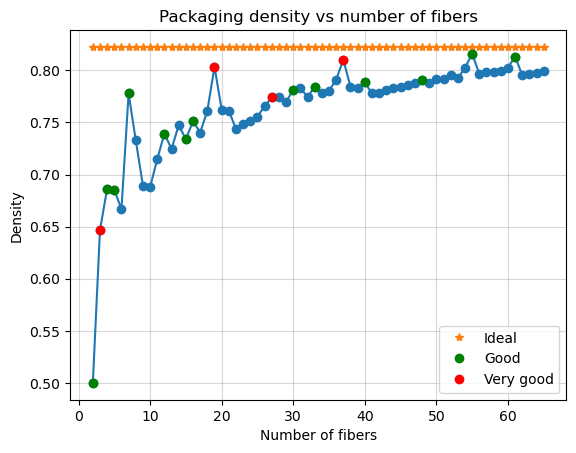

In [69]:
def pack_den(n, d_1, d_2):
    return n * (d_2/d_1) **2

def number_fiber_diam(n):
    return np.sqrt(n) / 0.9069

n, d_1= np.loadtxt("/Users/mcentenera/Nextcloud/HR_estimator/Pruebas.txt",usecols=(0, 1),unpack=True)
Q = np.loadtxt("/Users/mcentenera/Nextcloud/HR_estimator/Pruebas.txt", dtype=str, usecols=(2),unpack=True) 

import pandas as pd

df = pd.read_csv("/Users/mcentenera/Nextcloud/HR_estimator/Pruebas.txt")

# Añadir nueva columna
density = pack_den(n, d_1, 1)
df["Pack_density"] = density

# Guardar sobrescribiendo el archivo
df.to_csv("/Users/mcentenera/Nextcloud/HR_estimator/Pruebas_den.txt", sep="\t", index=False)

bad = []
good = []
n_good = []
okay = []
very_good = []
n_very_good = []

plt.plot(n, pack_den(n, d_1, 1), 'o-')
d_1_1 = estimated_d_1(n)
plt.plot(n, pack_den(n, d_1_1,1), '*', label = 'Ideal')
for i in range(0,len(Q)):
    if Q[i]=="'Bad'":
        bad.append(density[i])

    elif Q[i]=="'Good'":
        good.append(density[i])
        n_good.append(n[i])

    elif Q[i]=="'Okay'":
        okay.append(density[i])
        
    elif Q[i]=="'Very_good'":
        very_good.append(density[i])
        n_very_good.append(n[i])

for i in range(0,len(good)):
    if i==0:
        plt.plot(n_good[i], good[i], 'go', label = 'Good')
    else:
        plt.plot(n_good[i], good[i], 'go')

for i in range(0,len(very_good)):
    if i==0:
        plt.plot(n_very_good[i], very_good[i], 'ro', label = 'Very good')
    else:
        plt.plot(n_very_good[i], very_good[i], 'ro')

plt.title('Packaging density vs number of fibers')
plt.xlabel('Number of fibers')
plt.ylabel('Density')
plt.grid(which='minor', alpha=0)
plt.grid(which='major', alpha=0.5)
lgnd = plt.legend(loc="lower right")
# plt.savefig('/Users/mcentenera/Nextcloud/HR_estimator/Pack_density.png')

#coef = np.polyfit(n, d_1, 15)

# Crear el polinomio ajustado
#polinomio = np.poly1d(coef)

# Evaluar el polinomio en los puntos x
#x_fit = np.linspace(2, 160, 159)
#y_fit = polinomio(x_fit)
#plt.plot(x_fit[64:], pack_den(x_fit[64:], y_fit[64:], 1), 'ro')
plt.show()

In [80]:
num = number_fiber_diam(n)
print(np.round((num),0))

[2. 2. 2. 2. 3. 3. 3. 3. 3. 4. 4. 4. 4. 4. 4. 5. 5. 5. 5. 5. 5. 5. 5. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 8. 8. 8.
 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 9. 9. 9. 9. 9. 9.]


In [13]:
print(f'Los vert_good son {very_good}')

Los vert_good son [0.413818431990234, 0.5141916689194265, 0.4954009703207801, 0.5184958959560911]


In [66]:
d_1/1

array([2.   , 2.154, 2.414, 2.701, 3.   , 3.   , 3.304, 3.613, 3.813,
       3.923, 4.029, 4.236, 4.328, 4.521, 4.615, 4.792, 4.863, 4.863,
       5.122, 5.252, 5.439, 5.545, 5.651, 5.752, 5.828, 5.906, 6.014,
       6.138, 6.197, 6.291, 6.429, 6.486, 6.61 , 6.697, 6.746, 6.758,
       6.961, 7.057, 7.123, 7.26 , 7.346, 7.419, 7.498, 7.576, 7.65 ,
       7.724, 7.791, 7.886, 7.947, 8.027, 8.084, 8.179, 8.203, 8.211,
       8.384, 8.447, 8.524, 8.592, 8.646, 8.661, 8.829, 8.892, 8.961,
       9.017])

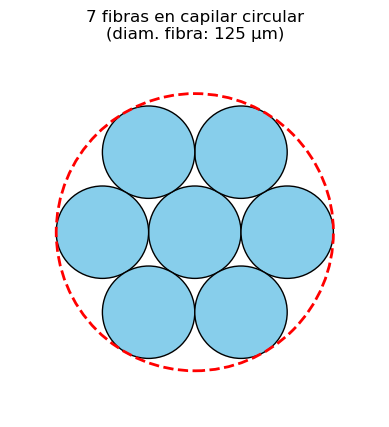

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math

def generate_hex_packing(n_layers, fiber_radius):
    """Genera coordenadas (x, y) para el empaquetamiento hexagonal compacto"""
    coords = [(0, 0)]  # centro
    for layer in range(1, n_layers + 1):
        for i in range(6):
            angle = math.pi / 3 * i
            for j in range(layer):
                x = (layer * fiber_radius * 2) * math.cos(angle) - (j * fiber_radius * 2) * math.sin(angle)
                y = (layer * fiber_radius * 2) * math.sin(angle) + (j * fiber_radius * 2) * math.cos(angle)
                coords.append((x, y))
    return coords

def plot_fiber_packing(fiber_diameter, num_fibers):
    fiber_radius = fiber_diameter / 2

    # Aproximamos cuántas capas de anillos concéntricos necesitamos
    n_layers = 0
    while True:
        estimated_fibers = 1 + 3 * n_layers * (n_layers + 1)
        if estimated_fibers >= num_fibers:
            break
        n_layers += 1

    coords = generate_hex_packing(n_layers, fiber_radius)
    coords = coords[:num_fibers]  # cortamos al número de fibras deseado

    # Estimamos el radio del capilar que los contiene
    max_r = max(np.hypot(x, y) for x, y in coords) + fiber_radius

    fig, ax = plt.subplots()
    ax.set_aspect('equal')


    # Dibujamos cada fibra
    for (x, y) in coords:
        circle = plt.Circle((x, y), fiber_radius, color='skyblue', ec='black')
        ax.add_artist(circle)

    # Dibujamos el capilar
    capillary = plt.Circle((0, 0), max_r, fill=False, color='red', linestyle='--', linewidth=2)
    ax.add_artist(capillary)

    ax.set_xlim(-max_r - fiber_radius, max_r + fiber_radius)
    ax.set_ylim(-max_r - fiber_radius, max_r + fiber_radius)
    ax.set_title(f'{num_fibers} fibras en capilar circular\n(diam. fibra: {fiber_diameter} μm)')
    plt.axis('off')
    plt.show()

# Ejemplo de uso
plot_fiber_packing(fiber_diameter=125, num_fibers=7)


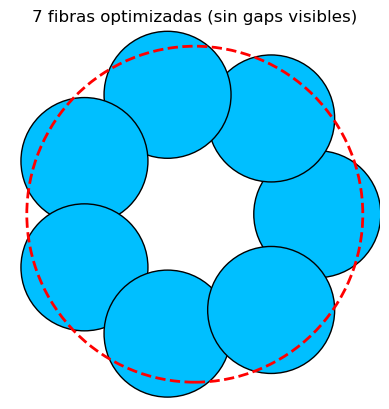

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def create_initial_positions(n, radius):
    # Posiciones iniciales aleatorias en el círculo
    angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
    r = radius * 0.5
    x = r * np.cos(angles)
    y = r * np.sin(angles)
    return np.stack((x, y), axis=1).flatten()

def pack_cost(positions, n, r_fiber):
    positions = positions.reshape((n, 2))
    total_penalty = 0
    for i in range(n):
        xi, yi = positions[i]
        # Penalizar si está fuera del círculo
        if np.hypot(xi, yi) + r_fiber > 1:
            total_penalty += 1000 * (np.hypot(xi, yi) + r_fiber - 1)**2
        # Penalizar solapamiento con otras fibras
        for j in range(i + 1, n):
            xj, yj = positions[j]
            dij = np.hypot(xi - xj, yi - yj)
            if dij < 2 * r_fiber:
                total_penalty += 1000 * (2 * r_fiber - dij)**2
    return total_penalty

def optimized_fiber_packing(num_fibers, fiber_diameter):
    r_fiber = fiber_diameter / 2
    # Normalizamos al capilar con radio 1
    scaled_r_fiber = r_fiber / (num_fibers ** 0.5 * r_fiber)
    initial = create_initial_positions(num_fibers, 1 - scaled_r_fiber)

    result = minimize(pack_cost, initial, args=(num_fibers, scaled_r_fiber),
                      method='L-BFGS-B', options={'maxiter': 1000})

    positions = result.x.reshape((num_fibers, 2))

    # Dibujar resultado
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    for (x, y) in positions:
        circle = plt.Circle((x, y), scaled_r_fiber, color='deepskyblue', ec='black')
        ax.add_artist(circle)

    capillary = plt.Circle((0, 0), 1, fill=False, color='red', linestyle='--', linewidth=2)
    ax.add_artist(capillary)
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_title(f'{num_fibers} fibras optimizadas (sin gaps visibles)')
    plt.axis('off')
    plt.show()

# Ejemplo de uso:
optimized_fiber_packing(num_fibers=7, fiber_diameter=125)
